In [1]:
import os, sys, wave, struct
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import platform
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
import sounddevice as sd
from IPython.display import display, Audio
if platform.system()=='Darwin': #MAC 
    import sounddevice as sd
import scipy    
import time
import soundfile as sf
from bokeh.io import output_notebook
from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
import mdct


#import scipy.io.wavfile

from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p

font = {'family' : 'serif',
        'size'   : 10
        }

plt.rc('font', **font)
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

%matplotlib inline
output_notebook()

Loading BokehJS ...

In [2]:
def play(y,Fe=44100):
    z=np.real(y)/(abs(np.real(y)).max())
    if platform.system()=='Darwin': #MAC (sous linux sounddevice a un comportement erratique)
        sd.play(z,Fe)
        return
    fichier=tempfile.mktemp()+'SON_TP.wav'
    sec=len(y)/Fe
    if sec<=20:
        rep=True
    if sec>20:
        print ('Vous allez créer un fichier son de plus de 20 secondes.')
        rep=None
        while rep is None:
            x=input('Voulez-vous continuer? (o/n)')
            if x=='o':
                rep=True
            if x=='n':
                rep=False
            if rep is None:
                print ('Répondre par o ou n, merci. ')
    if rep:
        sf.write(fichier,z,Fe)
        os.system('/usr/bin/play '+fichier+' &')

# Introduction

Les cloches sont parmi les instruments de musique les plus anciens et le son qu’elle produisent est souvent évocateur parce qu’il a bercé le quotidien des générations depuis environ 3000 ans, accompa- gnant petits et grands événements. Cette évocation tient en partie à la structure du spectre sonore : les modes propres de vibration sont en général accordés par les facteurs de cloches (dans le cas des bons instruments) pour que leurs fréquences suivent une série particulière, qui comporte notamment la tierce mineure (Mi bémol si la cloche est en Do). Cette série n’est pas harmonique mais les rapports entre fréquences propres sont tels qu’on perçoit une hauteur bien définie (celle à laquelle on chanterait la note entendue). Notamment la présence de la série 2-3-4, forte au début du son, vient renforcer la sensation de hauteur au voisinage du fondamental. Cette sensation est liée à un effet psychoacoustique (traitement du signal reçu par le cerveau).

Soit $f_{p}$ la fréquence correspondant à la hauteur perçue. L’analyse de la série des fréquences propres se traduit par la donnée d’un tableau d’environ 15 facteurs αn = fn/fp. Un ordre de grandeur est donné ci-après : 0.5 (bourdon), 1 (fondamental), 1.2 (tierce mineure), 1.5 (quinte), 2 (nominal), 2.5, 2.6, 2.7, 3, 3.3, 3.7, 4.2 (faux double octave), 4.5, 5, 5.9. Le timbre du son correspondant dépend de l’amplitude et de la décroissance de chacun de ces partiels.

Ce TP vise à mettre en oeuvre une méthode d’estimation spectrale à haute résolution pour effectuer l’analyse / synthèse de sons de cloche. Comme on peut le constater sur la figure 1, ce type de sons présente une forte décroissance temporelle.

Pour tenir compte de cette atténuation, on utilise le modèle Exponential Sinusoidal Model (ESM) :

$$
s[t] = \sum_{k=0}^{K-1} a_{k}e^{\delta_{k}t}e^{(2j\pi f_{k} +\phi_{k})}
$$


où à chaque fréquence $f_{k} \in $ [− $\frac{1}{2}$ , $\frac{1}{2}$ ] est associée une amplitude réelle $a_{k}$ > 0, une phase $\phi_{k}$ ∈] − $\pi$, $\pi$], et un facteur d’amortisement $\delta_{k} \in$  R. En définissant les amplitudes complexes $\alpha_{k} = a_{k}e^{\delta_{k} +2j\pi f_{k}}$ et les pôles complexes $z_{k} = e^{\delta_{k} +2j\pi f_{k}}$, ce modèle se réécrit sous la forme : 

$$
s[t] = \sum_{k=0}^{K-1} a_{k}z_{k}^{t}
$$

Le cas $\delta_{k}$ < 0 permet donc de modéliser des sinusoïdes à décroissance exponentielle, ce qui cor- respond aux solutions des équations de propagation physique. Les paramètres du modèle sont alors {$\delta_{k}$, $f_{k}$, $a_{k}$, $\phi_{k}$}$_{k \in {[0...K−1]}}$. Pour les estimer, nous utiliserons la méthode ESPRIT présentée dans le cours. Dans un premier temps, nous l’appliquerons à un signal synthétique pour mettre en évidence la supério- rité des méthodes à haute résolution sur l’analyse de Fourier en terme de résolution spectrale. Dans un deuxième temps, cette méthode sera appliquée à des sons de cloche.

# Signal synthétique

Nous nous intéressons ici à un signal synthétique de longueur N, constitué d’une somme de deux exponentielles complexes, dont les fréquences sont séparées d’un intervalle $\Delta f = \frac{1}{N}$ (ce qui correspond à la limite de la résolution de l’analyse de Fourier). Les phases seront tirées aléatoirement. On ne bruitera pas ce signal, de sorte que le signal observé x[t] sera égal à s[t]. On choisira par exemple les paramètres suivants : N = 63, $f_{0}$ = 14 , $f_{1}$ = $f_{0}$ + $\frac{1}{N}$ , $a_{0}$ = 1, $a_{1}$ = 10, $\delta_{0}$ = 0, $\delta_{1}$ = −0.05. Pour le synthétiser, on pourra utiliser la fonction fournie : 

$$
x = Synthesis(N,delta,f,a,phi);
$$

dont les arguments sont N, le vecteur delta des atténuations $\delta_{k}$ , le vecteur f des fréquences  $f_{k}$ , le vecteur
a des amplitudes $a_{k}$, et le vecteur phi des phases $\phi_{k}$.

## Analyse spectrale par transformation de Fourier

Observer le périodogramme de ce signal. On examinera brièvement la séparabilité des deux raies spectrales, sans zero-padding ($N_{fft}$ = N) et avec zero-padding ($N_{fft}$ = 1024 > N).



C:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


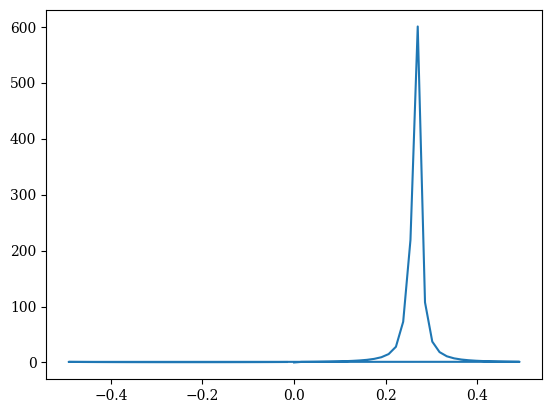

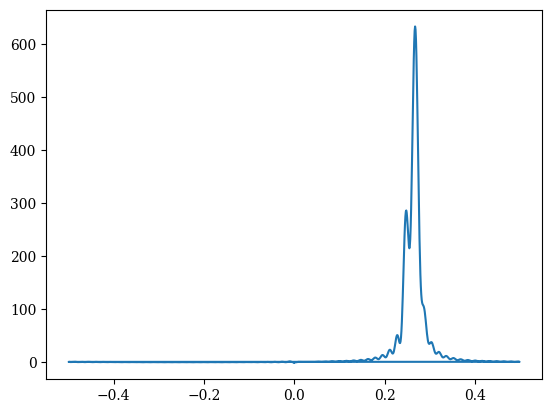

In [3]:
N= 63
f0= 1/4
f1=f0+(1/N)
a0=1
a1=10
delta0=0
delta1=-0.05
phi= 0

def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

x=Synthesis(N, delta0,f0, a0,phi)+Synthesis(N, delta1,f1, a1,phi)
#plt.plot(np.real(x))

f, Pxx_den = signal.periodogram(x)
plt.plot(f, Pxx_den)
plt.show()

f, Pxx_den = signal.periodogram(x,nfft=1024)
plt.plot(f, Pxx_den)
plt.show()

## Méthodes à haute résolution

On se propose d’écrire des fonctions MUSIC(x,n,K) et [delta,f] = ESPRIT(x,n,K) qui analysent le signal x de longueur N en utilisant les méthodes MUSIC et ESPRIT, avec un espace signal de dimension K et un espace bruit de dimension n − K, et des vecteurs de données de longueur n comprise entre K + 1 et N − K + 1. Pour traiter nos signaux synthétiques, on pourra choisir n = 32 et K = 2. Les deux méthodes partagent les étapes suivantes :

     1. Calcul de la matrice de corrélation

La matrice de corrélation du signal observé est définie par la relation

$$
R_{xx}= \frac{1}{l} X X^{h}
$$

où $X$ est une matrice de Hankel de dimension n × l contenant les $N = n + l − 1$ échantillons du signal :

$$
\begin{bmatrix} x[0] & x[1] & . & . &. & x[l-1] \\ x[1] & x[2] & . & . &. & x[l] \\ . & . & . & . &. & . \\ . & . & . & . &. & . \\ . & . & . & . &. & . \\ x[n-1] & x[n] & . & . &. & x[N-1] \\\end{bmatrix}
$$


La matrice X pourra être construite avec la fonction hankel.

     2. Estimation de l’espace signal

On pourra diagonaliser la matrice $R_{xx}$ à l’aide de la commande [U1,Lambda,U2] = svd(Rxx). La matrice $R_{xx}$ étant symétrique positive, les vecteurs colonnes des matrices $U_{1} $ et $U_{2} $ (de dimension n × n) sont vecteurs propres de $R_{xx}$, associés aux n valeurs propres rangées dans la matrice diagonale $\Lambda$ par ordre décroissant (on a alors $R_{xx} = U_{1}  \Lambda U_{1}^{H} = U_{2}  \Lambda U_{2}^{H} $). On pourra ainsi extraire de $U_{1} $ (ou de $U_{2} $) une base de l’espace signal $W$ (de dimension n × K).

### Algorithme ESPRIT

L’algorithme ESPRIT vise dans un premier temps à estimer les fréquences et les facteurs d’amortissement : 

     3.  Estimation des fréquences et des facteurs d’amortissement

Pour estimer les fréquences, on pourra procéder de la façon suivante :

   - extraire de $W$ les matrices $W↓$ (obtenue en supprimant la dernière ligne de W) et W↑ (obtenue en supprimant la première ligne de $W$) ;
   - calculer $\phi = ((W↓^{H} W↓)^{-1} W↓^{H} W↑) = W↓^{†} W↑$, où le symbole † est l’opérateur de pseudo inverse (fonction pinv de Matlab ou fonction numpy.linalg.pinv de Python).
   - calculer les valeurs propres de $\phi$ à l’aide de la fonction eig de Matlab ou de la fonction numpy.linalg.eig de Python (on rappelle que les valeurs propres de $\phi$ sont les pôles $z_{k} = e^{\delta_{k} +2j\pi f_{k}}$).En déduire $\delta_{k} =ln(|z_{k}|)$ et $f_{k} = \frac{1}{2\pi}angle(z_{k})$.
    
    4.  Estimation des amplitudes et des phases 

Il s’agit à présent d’écrire une fonction

$$
 [a,phi] = LeastSquares(x,delta,f)
$$


qui estime les amplitudes $a_{k}$ et les phases $\phi_{k}$ par la méthode des moindres carrés, connaissant le signal x, les atténuations $\delta_{k}$ et les fréquences fk. Les amplitudes complexes sont ainsi déterminées par la relation

$$
\alpha = ((V^{N})^{H} V^{N})^{-1}(V^{N})^{H})x = (V^{N})^{†} x
$$

où x est le vecteur $[x[0], . . . , x[N−1]]^{T}$ et $V^{N}$ est la matrice de Vandermonde de dimension $ N×K$, dont les coefficients vérifient la relation $V^{N} =z_{k}(t)$ pour tous(t,k)∈{0...N−1}×{0...K−1}.
(t,k)
Pour calculer la matrice VN, il est possible d’éviter d’utiliser une boucle for en remarquant que $ln (V_{(t,k)}^{N} ) = t(\delta_{k}+ 2j \pi f_{k})$. Ainsi, la matrice contenant les coefficients $ln (V^{N} )$ s’exprime comme le produit d’un vecteur colonne par un vecteur ligne. On en déduira $a_{k} = |\alpha_{k}|$ et $\phi_{k} = angle(\alpha_{k})$ pour tout $k \in$ {0 . . . K − 1}.

     5. Application aux signaux synthétiques

Appliquer les fonctions ESPRIT et LeastSquares au signal précédemment synthétisé. Commenter.



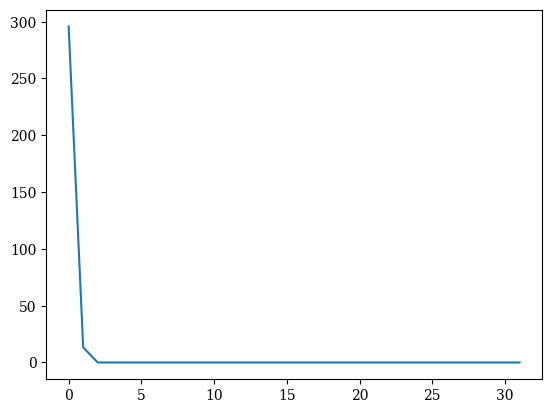

(63, 2)
[-5.0000000e-02  4.4408921e-16] [0.26587302 0.25      ] [10.  1.] [-6.01046990e-15  7.25461358e-15]


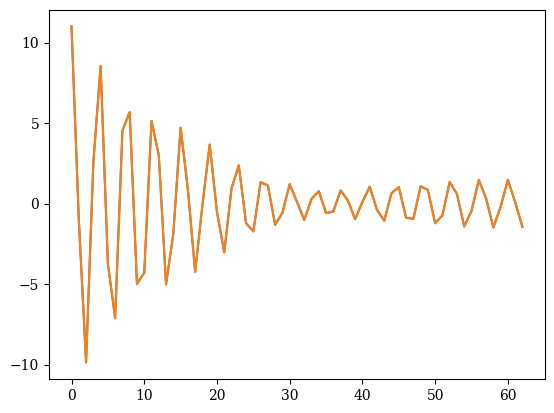

1.6034404639951366e-13


In [4]:
#Paramètres initiaux
n=32
K= 2

#Fonction LeastSquare
def LeastSquare(x_,delta_,f_):
    #Estimation des amplitudes et des phases
    N_=len(x_)
    K_=len(f_)
    t_ =np.arange(0,N_)
    k=np.arange(0,K_)

    #calcul de Vn

    log_V_N= t_[:,None]*(delta_+2j*np.pi*f_)
    V_N=np.exp(log_V_N)
    print(V_N.shape)

    #alpha =
    alpha =np.linalg.pinv(V_N)@x_

    #calcul a
    a=np.abs(alpha)
    phi =np.angle(alpha)
    
    return a,phi


def ESPRIT(x_,n_,K_):
    
    N_ = len(x_)
    l_ = N_-n_+1


    X=scipy.linalg.hankel(x_[:n],x_[n_-1:N_])
    
    
    #Matrice Rxx
    Rxx=(1/l_)*(X@(np.conjugate(X.T)))

    #diagonalisation
    U1,Lambda,U2 = np.linalg.svd(Rxx)
    plt.plot(np.abs(Lambda))
    plt.show()
    
    #Création de W
    W=U1[:,:K_]

    W_down=W[:-1,:]
    W_up=W[1:,:]


    #création de phi
    phi_ = np.linalg.pinv(W_down)@W_up

    #calcul de ses valeurs propres
    z_ =np.linalg.eig(phi_)[0]
    delta_=np.log(np.abs(z_))
    f_= (1/(2*np.pi))*np.angle(z_)
    
    a_,phi_ = LeastSquare(x_,delta_,f_)
    return delta_, f_, a_, phi_

delta_est,f_est, a_est, phi_est = ESPRIT(x,n,K)

print(delta_est,f_est, a_est, phi_est)
x_est=Synthesis(N,delta_est,f_est, a_est, phi_est)
plt.plot(np.real(x))
plt.plot(np.real(x_est))
plt.show()
#valeur RMS de l'erreur
print(np.sqrt(np.sum(np.square(np.abs(x-x_est)))))

### Méthode MUSIC

On rappelle que le pseudo-spectre MUSIC est défini par $P(z) =\frac{1}{∥ W_{⊥}^{H} v^{n}(z)∥^{2}}$ 

     6. Affichage du pseudo-spectre MUSIC

Écrire une fonction MUSIC(x,n,K) qui affiche le logarithme du pseudo-spectre comme une fonction des deux variables $f \in $ [0, 1] et $\delta \in$  [−0.1, 0.1] (on pourra utiliser la fonction surf de Matlab ou la fonction plot_surface de Python Matplotlib). Appliquer la fonction MUSIC au signal précédemment synthétisé, et vérifier que le pseudo-spectre fait bien apparaître les deux pôles $z_{k} = e^{\delta_{k} +2j\pi f_{k}}$.



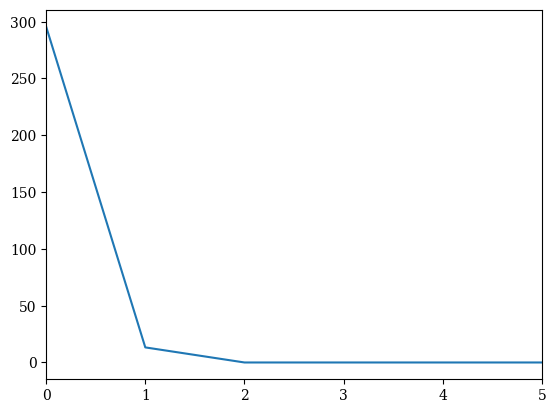

(32, 30)


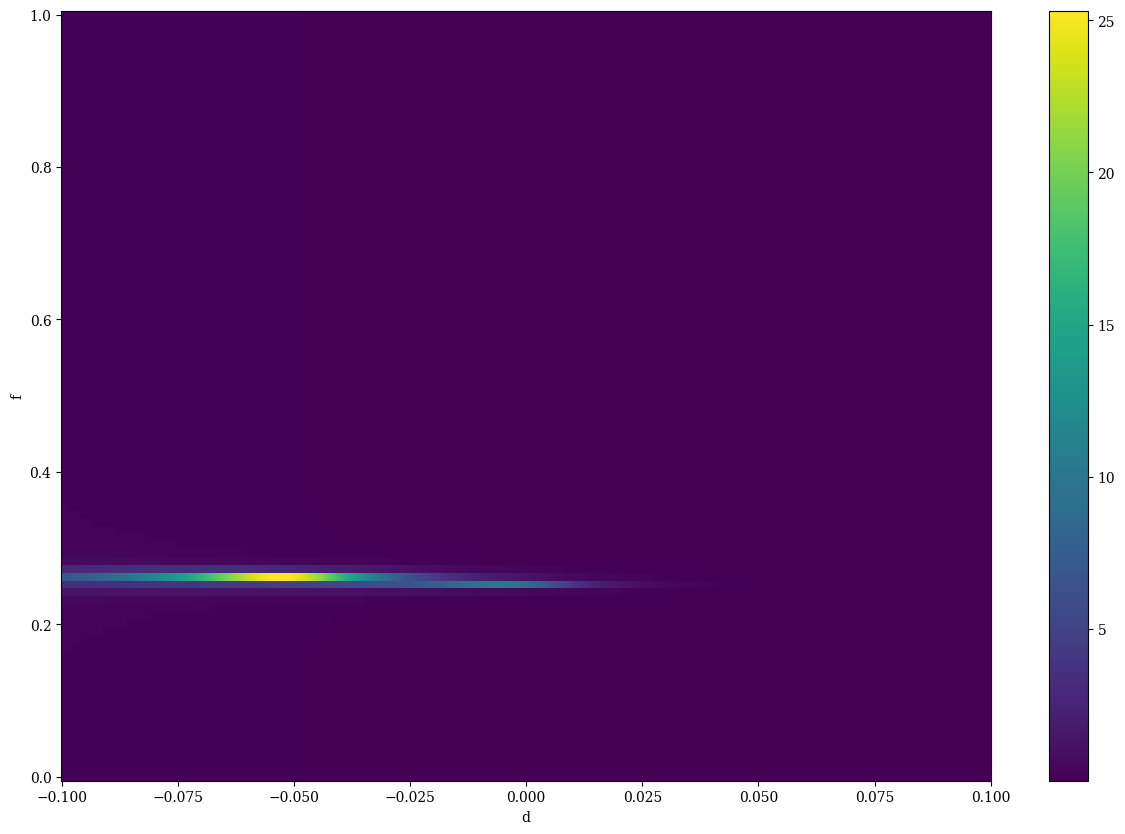

(100, 1000) (100, 1000) (100, 1000)


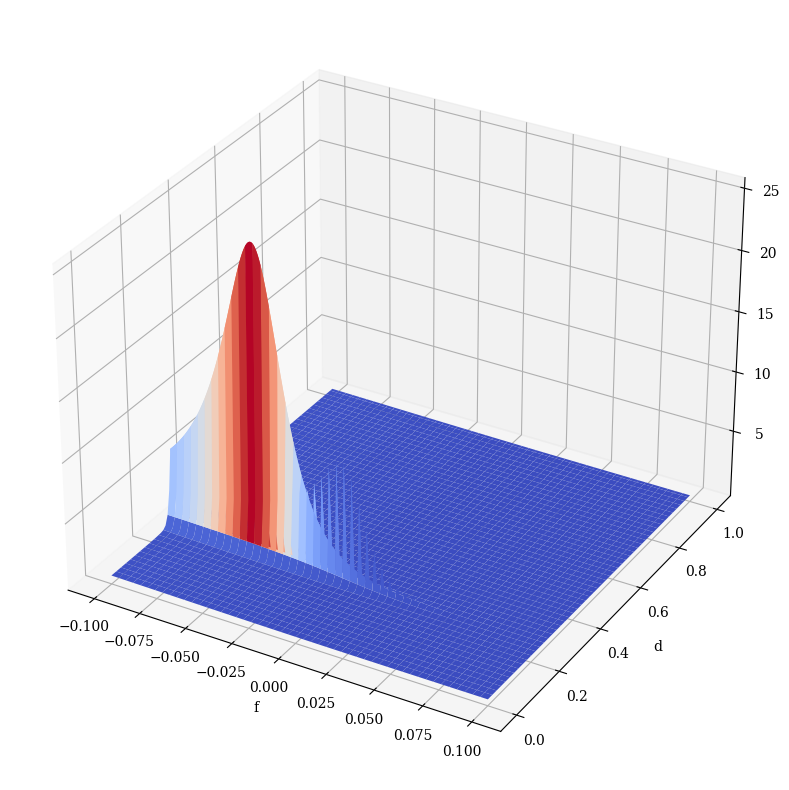

In [5]:
#pseudo spectre

def MUSIC(x,n,K):
    N = len(x)
    l = N-n+1

    X=scipy.linalg.hankel(x[:n],x[n-1:N])

    #Matrice Rxx
    Rxx=(1/l)*X@(np.conjugate(X).T)

    #diagonalisation
    [U1,Lambda,U2] = np.linalg.svd(Rxx)
    plt.plot(np.abs(Lambda))
    plt.xlim(0,5)
    plt.show()

    #Création de W
    W_per=U1[:,K:]
    print(W_per.shape)

    #création v_n
    dim_f=100
    dim_d=1000
    f=np.linspace(0,1,dim_f)
    d= np.linspace(-0.1,0.1,dim_d)
    t=np.arange(n)

    P=np.zeros((dim_f,dim_d))
    for i in range(dim_f):
        for j in range(dim_d):
            v=np.exp(t*(d[j]+2j*np.pi*f[i]))
            P[i,j]=np.sum(np.square(np.abs(np.conjugate(W_per.T)@v)))


    d_mesh,f_mesh= np.meshgrid(d,f)


    plt.figure(figsize=(15,10))
    plt.pcolormesh(d,f,1/P)
    plt.xlabel("d")
    plt.ylabel('f')
    plt.colorbar()
    plt.show()
    
    print(d_mesh.shape,f_mesh.shape,P.shape)
    fig,ax=plt.subplots(subplot_kw={"projection":"3d"},figsize=(15,10))
    ax.set_xlabel("f")
    ax.set_ylabel("d")
    ax.set_zlabel("P")
    surf = ax.plot_surface(d_mesh,f_mesh,1/P,cmap=cm.coolwarm,antialiased=True)

MUSIC(x,n,K)

# Signaux audio

Nous nous proposons maintenant d’appliquer les fonctions développées dans la partie précédente à des sons de cloche.

## Analyse spectrale par transformation de Fourier


Examiner le périodogramme du signal cloche.wav et comparer la série de ses fréquences propres aux valeurs données en introduction.



1536
8000


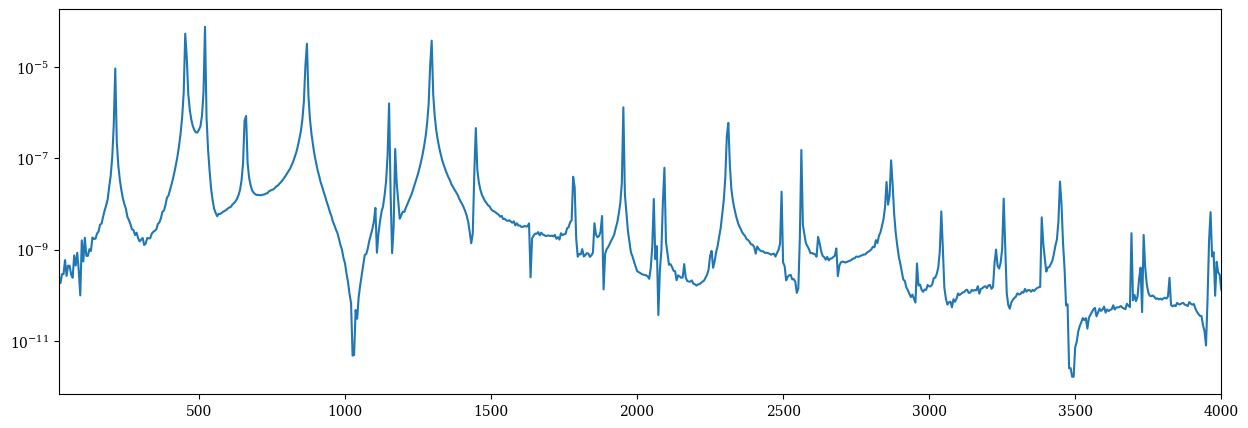

In [6]:
[x,Fe]=sf.read("ClocheB.wav")
display(Audio(x ,rate=Fe))

#x=x[10000:11536]
x=x[10000:10000+1536]
print(len(x))
print(Fe)
f, Pxx_den = signal.periodogram(x,fs=Fe)
plt.figure(figsize=(15,5))
plt.plot(f[1:], Pxx_den[1:])
plt.semilogy()
plt.xlim(20,4000)
plt.show()




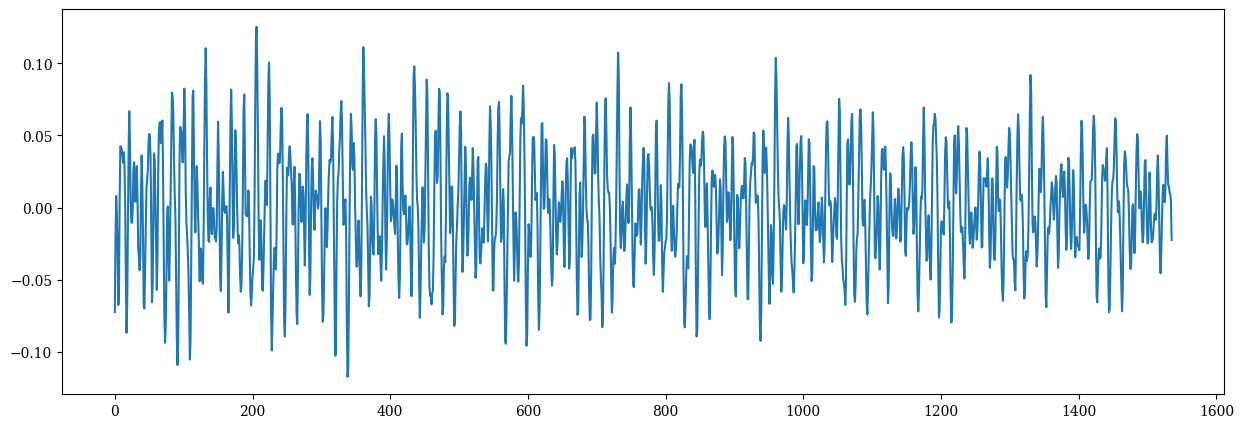

In [7]:
plt.figure(figsize=(15,5))
plt.plot(x)
plt.show()


## Méthode à haute résolution

Il s’agit à présent d’appliquer l’algorithme ESPRIT à ce signal. On posera K = 54, n = 512 et l = 2n = 1024 (d’où N =n+l−1=1535). Afin de garantir que le modèle de signal soit vérifié sur la fenêtre d’analyse (amortissement exponentiel), on extraira un segment de longueur N dont le début sera postérieur au maximum de l’enveloppe de la forme d’onde. On pourra ainsi commencer au 10000 ème échantillon.

Appliquer la fonction `ESPRIT` au signal extrait afin d’en estimer les fréquences propres et les atténuations correspondantes. En déduire les amplitudes et les phases à l’aide de la fonction LeastSquares. Enfin, écouter le signal resynthétisé à l’aide de la fonction `Synthesis` (sur une durée plus longue que le segment extrait, afin de bien mettre en évidence les résonnances du son), et commenter.

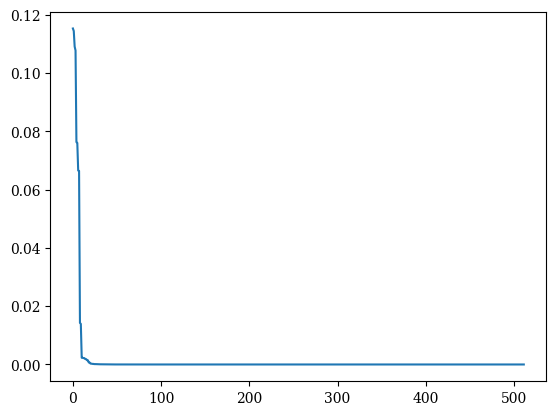

(1536, 54)
[ 3961.55235603 -3961.55235603  3449.84135441 -3449.84135441
  3386.38588928 -3386.38588928  3256.69626129 -3256.69626129
  3043.18068467 -3043.18068467  2870.92003893 -2870.92003893
  2857.36903653 -2857.36903653   212.57139056  -212.57139056
   520.11852867  -520.11852867   454.73500323  -454.73500323
   455.80090894  -455.80090894   659.02344157  -659.02344157
   867.9644403   -867.9644403   1295.07678172 -1295.07678172
  1108.29251198 -1108.29251198  1150.5838669  -1150.5838669
  1173.31461948 -1173.31461948  1446.16450245 -1446.16450245
  2561.9073786  -2561.9073786   2495.35709481 -2495.35709481
  2310.28189911 -2310.28189911  1783.86272523 -1783.86272523
  2092.32247745 -2092.32247745  2056.31312983 -2056.31312983
  1876.88830891 -1876.88830891  1952.54383425 -1952.54383425
  1946.940421   -1946.940421  ]
[-9.37728239e-04 -9.37728239e-04 -9.58157889e-04 -9.58157889e-04
 -4.35399884e-04 -4.35399884e-04 -2.52609503e-04 -2.52609503e-04
 -9.53821166e-04 -9.53821166e-04 -1

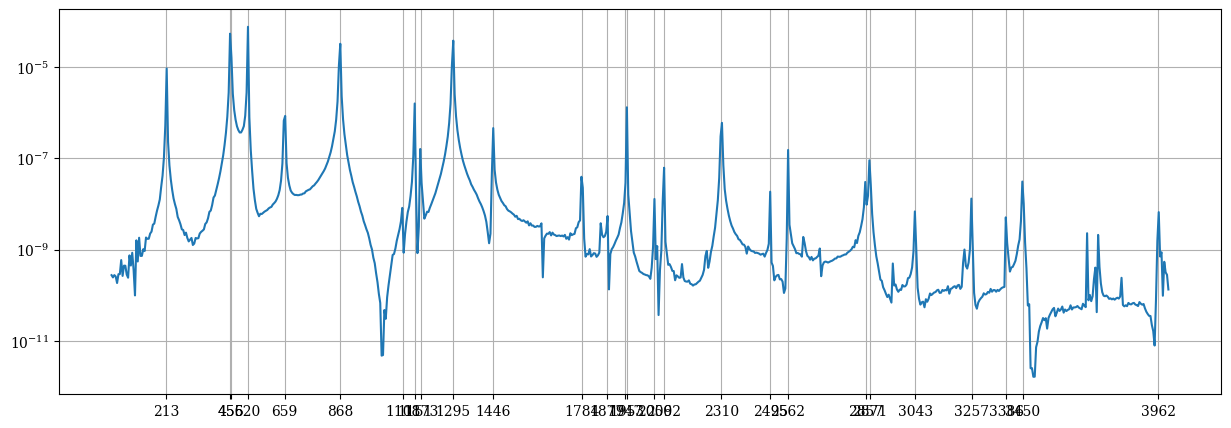

In [8]:
K=54
n=len(x)//3

delta_est,f_est, a_est, phi_est = ESPRIT(x,n,K)

print(f_est*Fe)
print(delta_est)
delta_est[delta_est>0]=-1e-6
f, Pxx_den = signal.periodogram(x,fs=Fe)
plt.figure(figsize=(15,5))
plt.plot(f[1:], Pxx_den[1:])
plt.semilogy()
plt.xticks(f_est[f_est>0]*Fe)
plt.grid()
plt.show()



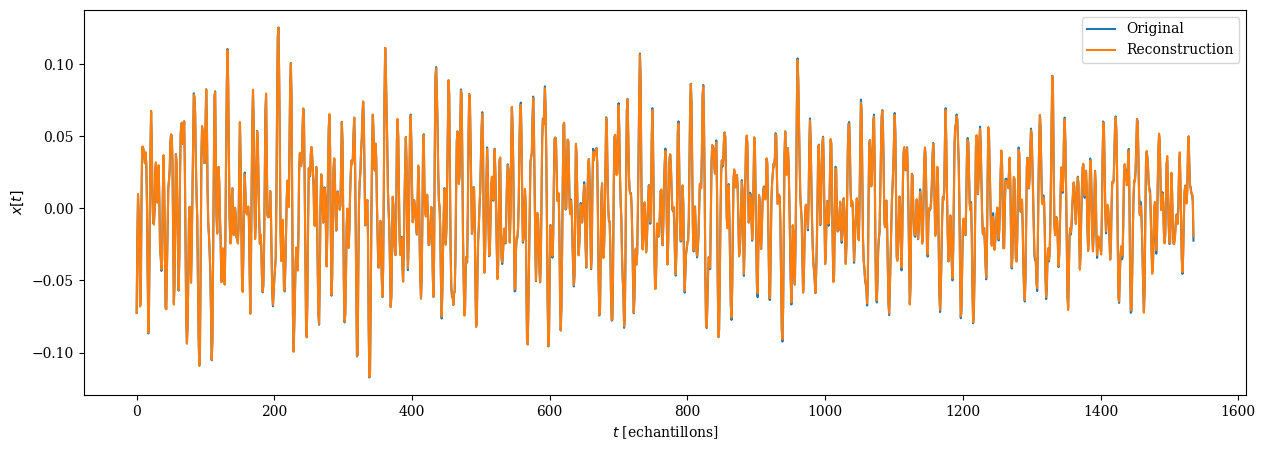

In [9]:

y = np.real(Synthesis(len(x),delta_est,f_est,a_est,phi_est,RSB=False))

plt.figure(figsize = (15,5))
plt.plot(x, label = "Original")
plt.plot(np.real(y),label = "Reconstruction")
plt.xlabel("$t$ [echantillons]")
plt.ylabel("$x[t]$")
plt.legend()
plt.show()


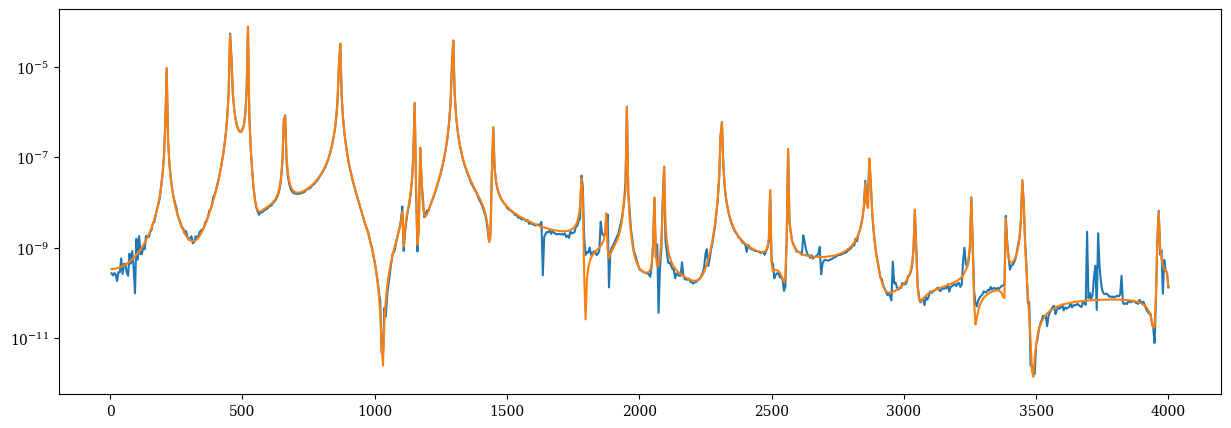

In [10]:
f, Pxx_den = signal.periodogram(x,fs=Fe)
f, Pyy_den = signal.periodogram(y,fs=Fe)
plt.figure(figsize=(15,5))
plt.plot(f[1:], Pxx_den[1:])
plt.plot(f[1:], Pyy_den[1:])
plt.semilogy()
plt.show()

In [11]:
display(Audio(x ,rate=Fe))
display(Audio(y ,rate=Fe))


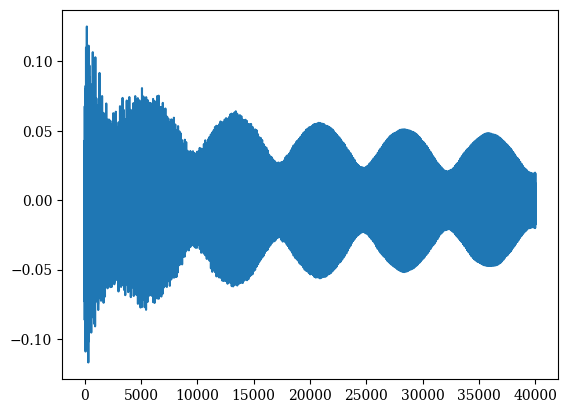

In [12]:
y = np.real(Synthesis(Fe*5,delta_est,f_est,a_est,phi_est,RSB=False))
display(Audio(y ,rate=Fe))
#plt.plot(x)
plt.plot(np.real(y))
plt.show()